## Diffusion Distances
### Random Walk Behavoir

We investigate the expected length of random walks from the boundary of a district to another district.

In [90]:
import matplotlib.pyplot as plt
from gerrychain.random import random
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain,
                        proposals, updaters, constraints, accept, Election)
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.metrics import mean_median, efficiency_gap, polsby_popper, partisan_gini
from functools import (partial, reduce)
import pandas
import geopandas as gp
from maup import assign
import maup
import numpy as np
import networkx as nx
import pickle
import seaborn as sns
import pprint
import operator
import scipy
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize
from gerrychain.constraints import (
    Validator,
    single_flip_contiguous,
    within_percent_of_ideal_population,
)

### Functions

In [2]:
## This function takes a name of a shapefile and returns a tuple of the graph
## and its associated dataframe
def build_graph(filename):
    print("Pulling in Graph from Shapefile: " + filename)
    graph = Graph.from_file(filename)
    df = gp.read_file(filename)
    return(graph, df)

In [89]:
def config_markov_chain(initial_part, iters=1000, epsilon=0.05):
    # The recom proposal needs to know the ideal population for the districts so
    # that we can improve speed by bailing early on unbalanced partitions.
    ideal_population = sum(initial_part["population"].values()) / len(initial_part)


    # We use functools.partial to bind the extra parameters (pop_col, pop_target,
    # epsilon, node_repeats) of the recom proposal.
    proposal = partial(recom,
                       pop_col="TOTPOP",
                       pop_target=ideal_population,
                       epsilon=epsilon,
                       node_repeats=1)

    # To keep districts about as compact as the original plan, we bound the number
    # of cut edges at 2 times the number of cut edges in the initial plan.
    compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]),
                        2*len(initial_part["cut_edges"]))

    cs = [constraints.within_percent_of_ideal_population(initial_part, epsilon)]


    # Configure the MarkovChain.
    return MarkovChain(proposal=proposal, constraints=cs, accept=accept.always_accept,
                       initial_state=initial_part, total_steps=iters)

In [102]:
def config_flip_chain(initial_part, iters=1000, epsilon=0.05):
    # The recom proposal needs to know the ideal population for the districts so
    # that we can improve speed by bailing early on unbalanced partitions.
    ideal_population = sum(initial_part["population"].values()) / len(initial_part)


    # To keep districts about as compact as the original plan, we bound the number
    # of cut edges at 2 times the number of cut edges in the initial plan.
    compactness_bound = constraints.UpperBound(lambda p: len(p["cut_edges"]),
                        2*len(initial_part["cut_edges"]))

    cs = [constraints.within_percent_of_ideal_population(initial_part, epsilon),
         single_flip_contiguous, compactness_bound]


    # Configure the MarkovChain.
    return MarkovChain(proposal=propose_random_flip,
                       constraints=cs, accept=accept.always_accept,
                       initial_state=initial_part, total_steps=iters)

### Set up initial partions to random walk over

In [4]:
graph, df = build_graph("../IA_counties/IA_counties.shp")

Pulling in Graph from Shapefile: ../IA_counties/IA_counties.shp


In [5]:
total_population = sum(df.TOTPOP.values)
ideal_population = total_population / 4

In [6]:
my_updaters = { "population": updaters.Tally("TOTPOP", alias="population")}

In [7]:
initial_partition = GeographicPartition(graph, assignment="CD",
                                        updaters=my_updaters)

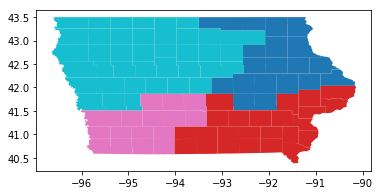

In [8]:
initial_partition.plot(df)

In [9]:
chain = config_markov_chain(initial_partition, iters=100, epsilon=0.01)

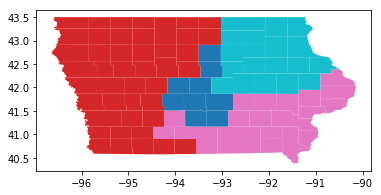

In [113]:
for part in chain:
    pass

final_part = part
final_part.plot(df)

In [114]:
n = len(list(graph.nodes()))

centroids = df.centroid
c_x = centroids.x
c_y = centroids.y
pos = {node:(c_x[node],c_y[node]) for node in graph.nodes}  

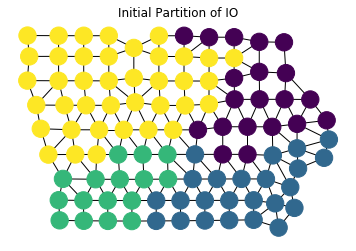

In [12]:
plt.figure()
plt.title("Initial Partition of IO")
nx.draw(graph,pos=pos, node_color=[initial_partition.assignment[x] for x in graph.nodes()])
plt.show()

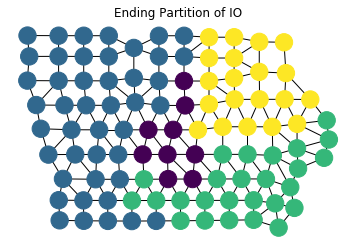

In [115]:
plt.figure()
plt.title("Ending Partition of IO")
nx.draw(graph,pos=pos, node_color=[final_part.assignment[x] for x in graph.nodes()])
plt.show()

### Random Walks

In [60]:
# Given a base_partition with some labelling and a new_partition, we would like
# the labelling of new_partition to be as close as possible to the base_partition.
# That is, we would like as many nodes as possible to remain in the same district.
# This function implements a greedy algorithm to do so (thus is not necessarily optimal).
# It outputs a dictionary that takes the labelling given by new_partition and
# says which label it should get.  It also outputs the number of displaced nodes.

def greedy_hamming(base_partition, new_partition):
    names = [j for j in range(len(base_partition))]
    new_names = {}
    for i in range(1, 5):
        intersection_sizes = {}
        for name in names:
            intersection_sizes.update({len(set(base_partition.assignment.parts[name]).intersection(set(new_partition.assignment.parts[i]))): name})
        new_names.update({i: intersection_sizes[max(intersection_sizes.keys())]})
        names.remove(intersection_sizes[max(intersection_sizes.keys())])
    tot_nodes = len(new_partition.assignment)
    final_int_sizes = []
    for i in range(num_dist):
        x = len(set(new_partition.assignment.parts[new_names[i]]).intersection(set(base_partition.assignment.parts[i])))
        final_int_sizes.append(x)
    ham_dist = tot_nodes - sum(final_int_sizes)
    return new_names, ham_dist;

In [40]:
## greedy_hamming depends on globals not defined.
# greedy_hamming(initial_partition, final_part)

### Functions from random walks from one district to another.

General outline:
* Choose source and target district
* Create set of target boundary nodes
* For each boundary node in the source randomly walk until reaching
* a boundary node in the target, and keep track of steps.

In [4]:
## This function take a name for the walker attribute, the name of the 
## target attribute, the name of the times attribute, the source 
## indentifier, and the target identifier.  It returns a dictionary of
## random walk state.
def init_rand_walk_pair_state(source, target, part, walker_name="walkers",
                              target_name="target", times_name="times", graph_name="graph"):
    rand_walk = dict()
    rand_walk[graph_name] = part.graph
    rand_walk[walker_name] = np.array(list(filter(lambda x: part.assignment[x] == source,
                                                  graph.nodes())))
    rand_walk[target_name] = set(filter(lambda x: part.assignment[x] == target,
                                         graph.nodes()))
    rand_walk[times_name] = np.zeros(len(rand_walk[walker_name]))
    return rand_walk

In [5]:
## This function takes a dictionary containing random walk state, and the 
## indentifers for the attributes, updates them if nescessary and returns
## True if the walk is ongoing and False if it is done.
def update_walkers(state, walkers="walkers", target="target", times="times",
                   graph="graph"):
    not_done = []
    for i in range(len(state[walkers])):
        if state[walkers][i] in state[target]:
            not_done.append(False)
        else:
            state[times][i] += 1
            state[walkers][i] = random.choice(list(state[graph].neighbors(state[walkers][i])))
            not_done.append(True)
#     print(not_done)
    return any(not_done)

In [6]:
## This function preforms random walker from distric d1 to district d2, for iters times.
## d1 and d2 are the identifiers for districts 1 and 2 in the passed partition.
def random_pair_walks(d1, d2, part, iters=1000):
    time_data = []
    for i in range(iters):
        rand_walk_state = init_rand_walk_pair_state(d1, d2, part)
        while update_walkers(rand_walk_state):
            pass
        time_data.extend(rand_walk_state["times"])
    return time_data

### Functions for random walks between two districting plan boundaries

In [7]:
## This functions takes two plans and returns a dictionary that is used to store the current
## state of a random walk between the boundary of the two plans.

def init_random_walk_plans_state(plan1, plan2, walker_name="walkers", target_name="target",
                                 times_name="times", graph_name="graph"):
    rand_walk = dict()
    rand_walk[graph_name] = plan1.graph
    plan1_bound = reduce(lambda ns, e: set(e) | ns, plan1["cut_edges"], set())
    plan2_bound = reduce(lambda ns, e: set(e) | ns, plan2["cut_edges"], set())
    
    rand_walk[walker_name] = np.array(list(plan1_bound))
    rand_walk[target_name] = plan2_bound
    rand_walk[times_name] = np.zeros(len(rand_walk[walker_name]))
    
    return rand_walk

In [8]:
## This function takes two plans and returns the simulated time intervals it took to walk from
## boundary nodes on the first plan to boundary nodes on the second.

def random_plans_walks(plan1, plan2, iters=1000):
    time_data = []
    for i in range(iters):
        rand_walk_state = init_random_walk_plans_state(plan1, plan2)
        while update_walkers(rand_walk_state):
            pass
        time_data.extend(rand_walk_state["times"])
    return time_data

In [9]:
## This function takes two plans and simulates the expected time to walk from the boundary
## of the first plan to the boundary and adds the expected time to walk from the boundary
## of the second plan to the first.

def estimate_bound_walk_metric(plan1, plan2, plots=False, iters=1000):
    walk_times_12 = random_plans_walks(plan1, plan2, iters=iters)
    walk_times_21 = random_plans_walks(plan2, plan1, iters=iters)
    
    if all(list(map(lambda x: x == 0, walk_times_12 + walk_times_21))): return 0
    
    score = np.mean(np.ma.masked_equal(walk_times_12, 0)) + np.mean(np.ma.masked_equal(walk_times_21,0))
    
    if plots:
        fig, axs = plt.subplots(2, 2, figsize=(15,10))
        axs[0, 0].set_title("Random walk times from plan1 to plan2")
        axs[0, 0].set_ylabel("Walk time")
        axs[0, 0].boxplot(walk_times_12)

        axs[1, 0].set_xlabel("Walk time")
        axs[1, 0].set_ylabel("Frequency")
        sns.distplot(walk_times_12, kde=False, ax=axs[1, 0])

        axs[0, 1].set_title("Random walk times from plan2 to plan1")
        axs[0, 1].set_ylabel("Walk time")
        axs[0, 1].boxplot(walk_times_21)

        axs[1, 1].set_xlabel("Walk time")
        axs[1, 1].set_ylabel("Frequency")
        sns.distplot(walk_times_21, kde=False, ax=axs[1, 1])
        plt.show()
    
    return score

In [10]:
## This function takes two plans and calculates expected time to walk from the boundary
## of the first plan to the boundary of the second plan and visa versa.

def bound_walk_metric(plan1, plan2):
    score = dir_bound_walk_metric(plan1, plan2) + dir_bound_walk_metric(plan2, plan1)
    return score


## This function takes two plans and calculates expected time to walk from the boundary
## of the first plan to the boundary of the second plan.

def dir_bound_walk_metric(plan1, plan2):
    graph = plan1.graph
    adj = nx.to_numpy_matrix(graph, weight=None)
    trans = normalize(adj, norm="l1")
    plan1_bound = reduce(lambda ns, e: set(e) | ns, plan1["cut_edges"], set())
    plan2_bound = reduce(lambda ns, e: set(e) | ns, plan2["cut_edges"], set())
    contained_by_plan2 = set(filter(lambda x: all(list(map(lambda y: y in plan2_bound,
                                                   graph.neighbors(x)))), graph.nodes()))
    
    if plan1_bound == plan2_bound: return 0
    
    undercount = (contained_by_plan2 - plan2_bound) & plan1_bound
    
    to_delete = plan2_bound | contained_by_plan2
    starters = sorted(plan1_bound - to_delete)
    to_delete = list(reversed(sorted(list(to_delete))))
    plan1_bound = reduce(lambda shifted, x: list(map(lambda y: y-1 if y > x else y, shifted)), 
                         to_delete, starters)
    
#     print(to_delete)
#     print(starters)
#     print(plan1_bound)

    P = trans
    for node in to_delete:
        P = np.delete(P, node, 0)
        P = np.delete(P, node, 1)

    N = np.identity(P.shape[0]) - P
    N = np.linalg.inv(N)
#     print(P.shape)
    score = sum([sum(N[i]) for i in plan1_bound]) + len(undercount)
    
    return score / len(plan1_bound)

## Random Walks between boundaries of IO

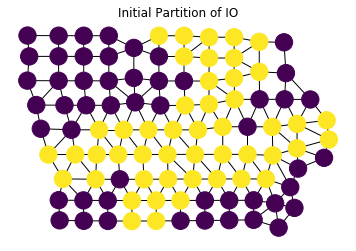

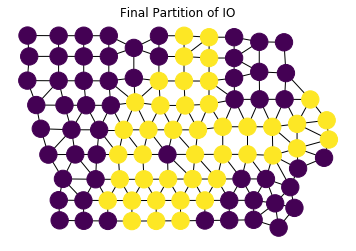

In [119]:
bn = reduce(lambda ns, e: set(e) | ns , initial_partition["cut_edges"], set())

plt.figure()
plt.title("Initial Partition of IO")
nx.draw(graph,pos=pos, node_color=[x in bn for x in graph.nodes()])
plt.show()

bn = reduce(lambda ns, e: set(e) | ns , final_part["cut_edges"], set())

plt.figure()
plt.title("Final Partition of IO")
nx.draw(graph,pos=pos, node_color=[x in bn for x in graph.nodes()])
plt.show()

In [156]:
bound_walk_metric(initial_partition, final_part)

11.637109217037613

In [155]:
# walk_bound_time_data = random_plans_walks(initial_partition, final_part)
estimate_bound_walk_metric(initial_partition, final_part, plots=False)

11.0683875

In [150]:
bound_walk_metric(initial_partition, initial_partition)

0

In [157]:
estimate_bound_walk_metric(initial_partition, initial_partition, plots=False)

0

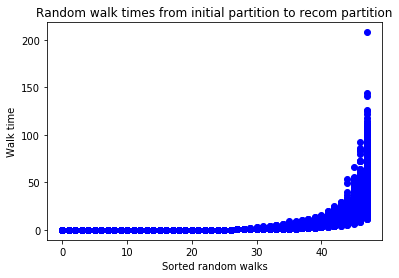

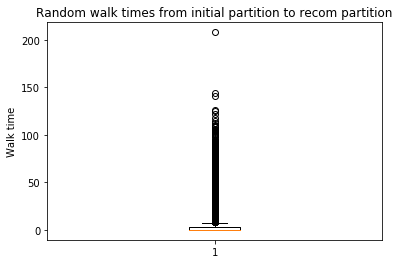

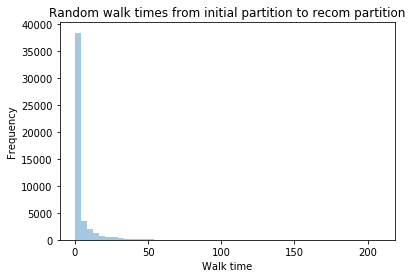

Mean 3.6619375
Median 0.0


In [176]:
plt.figure()
plt.title("Random walk times from initial partition to recom partition")
plt.ylabel("Walk time")
plt.xlabel("Sorted random walks")
for times in  walk_bound_time_data:
    plt.plot(sorted(times), "bo")
plt.show()

plt.figure()
plt.title("Random walk times from initial partition to recom partition")
plt.ylabel("Walk time")
plt.boxplot(walk_bound_times)
plt.show()

plt.figure()
plt.title("Random walk times from initial partition to recom partition")
plt.xlabel("Walk time")
plt.ylabel("Frequency")
sns.distplot(walk_bound_times, kde=False)
plt.show()

print("Mean", np.mean(walk_bound_times))
print("Median", np.median(walk_bound_times))

## Random Walks on Boundaries of AR

In [41]:
graph_AR = Graph.from_json("Data/BG05.json")
df_AR = gp.read_file("Data/BG05.shp")

In [44]:
df_AR.TOTPOP = list(map(int, df_AR.TOTPOP))

In [45]:
AR_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

In [46]:
total_population_AR = sum(df_AR.TOTPOP.values)
ideal_population_AR = total_population_AR / 4

In [48]:
parts = range(1, 5)
seed_part1 = recursive_tree_part(graph_AR, parts, pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.1, node_repeats=1)

seed_part2 = recursive_tree_part(graph_AR, parts, pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.1, node_repeats=1)

In [64]:
seed_part3 = recursive_tree_part(graph_AR, parts, pop_col="TOTPOP",
                                pop_target=ideal_population_AR,
                                epsilon=0.1, node_repeats=1)

In [65]:
AR_seed1 = GeographicPartition(graph_AR, assignment=seed_part1, updaters=AR_updaters)
AR_seed2 = GeographicPartition(graph_AR, assignment=seed_part2, updaters=AR_updaters)
AR_seed3 = GeographicPartition(graph_AR, assignment=seed_part3, updaters=AR_updaters)

In [84]:
chain = config_markov_chain(AR_seed1, iters=1000, epsilon=0.5)

In [86]:
for part in chain:
    print("*", end="")

AR_recom = part

****************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************************

In [95]:
chain = config_flip_chain(AR_seed1, iters=10000, epsilon=0.5)

In [96]:
for part in chain:
    pass
AR_flip = part

In [104]:
chain = config_flip_chain(AR_seed1, iters=1000, epsilon=0.5)

In [105]:
for part in chain:
    pass
AR_flip_comp = part

In [55]:
n_AR = len(list(graph_AR.nodes()))

centroids_AR = df_AR.centroid
c_x_AR = centroids_AR.x
c_y_AR = centroids_AR.y
pos_AR = {node:(c_x_AR[node],c_y_AR[node]) for node in graph_AR.nodes} 

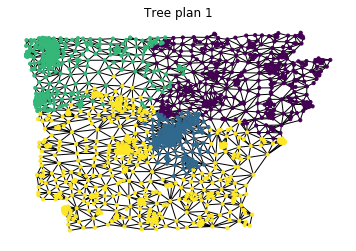

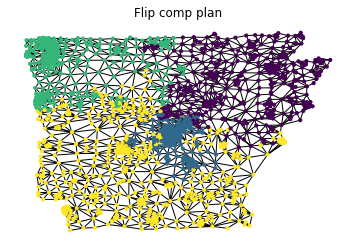

In [112]:
plt.figure()
plt.title("Tree plan 1")
nx.draw(graph_AR,pos=pos_AR, node_color=[AR_seed1.assignment[x] for x in graph_AR.nodes()],
        node_size=10)
plt.show()

# plt.figure()
# plt.title("Recom plan")
# nx.draw(graph_AR,pos=pos_AR, node_color=[AR_recom.assignment[x] for x in graph_AR.nodes()],
#         node_size=10)
# plt.show()

# plt.figure()
# plt.title("Flip plan")
# nx.draw(graph_AR,pos=pos_AR, node_color=[AR_flip.assignment[x] for x in graph_AR.nodes()],
#         node_size=10)
# plt.show()

# bn_flip = reduce(lambda ns, e: set(e) | ns , AR_flip["cut_edges"], set())
# plt.figure()
# plt.title("Flip plan")
# nx.draw(graph_AR,pos=pos_AR, node_color=[x in bn_flip for x in graph_AR.nodes()], node_size=10)
# plt.show()

plt.figure()
plt.title("Flip comp plan")
nx.draw(graph_AR,pos=pos_AR, node_color=[AR_flip_comp.assignment[x] for x in graph_AR.nodes()],
        node_size=10)
plt.show()

# bn_flip_comp = reduce(lambda ns, e: set(e) | ns , AR_flip_comp["cut_edges"], set())
# plt.figure()
# plt.title("Flip comp plan")
# nx.draw(graph_AR,pos=pos_AR, node_color=[x in bn_flip_comp for x in graph_AR.nodes()], node_size=10)
# plt.show()

# plt.figure()
# plt.title("Tree plan 2")
# nx.draw(graph_AR,pos=pos_AR, node_color=[AR_seed2.assignment[x] for x in graph_AR.nodes()],
#         node_size=10)
# plt.show()

# plt.figure()
# plt.title("Tree plan 3")
# nx.draw(graph_AR,pos=pos_AR, node_color=[AR_seed3.assignment[x] for x in graph_AR.nodes()],
#         node_size=10)
# plt.show()

In [ ]:
## Compare Seed 1, with the generated recom and flip

In [98]:
print("Distance between Seed and Recom")
print("Calculation:", bound_walk_metric(AR_seed1, AR_recom))
print("Estimation:", estimate_bound_walk_metric(AR_seed1, AR_recom, plots=False, iters=100))

Distance between Seed and Recom
Calculation: 336.26781337253414
Estimation: 334.8378985552962


In [99]:
print("Distance between Seed and Flip")
print("Calculation:", bound_walk_metric(AR_seed1, AR_flip))
print("Estimation:", estimate_bound_walk_metric(AR_seed1, AR_flip, plots=False, iters=100))

Distance between Seed and Flip
Calculation: 177.82829640206475
Estimation: 176.976957952468


In [100]:
print("Distance between Flip and Recom")
print("Calculation:", bound_walk_metric(AR_flip, AR_recom))
print("Estimation:", estimate_bound_walk_metric(AR_flip, AR_recom, plots=False, iters=100))

Distance between Flip and Recom
Calculation: 152.8529953299512
Estimation: 152.2142360268285


In [108]:
print("Distance between Seed and Flip Comp")
print("Calculation:", bound_walk_metric(AR_seed1, AR_flip_comp))
print("Estimation:", estimate_bound_walk_metric(AR_seed1, AR_flip_comp, plots=False, iters=100))

Distance between Seed and Flip Comp
Calculation: 69.1224368398723
Estimation: 64.78434002729577


In [109]:
print("Distance between Flip comp and Recom")
print("Calculation:", bound_walk_metric(AR_flip_comp, AR_recom))
print("Estimation:", estimate_bound_walk_metric(AR_flip_comp, AR_recom, plots=False, iters=100))

Distance between Flip comp and Recom
Calculation: 258.59932189992537
Estimation: 260.8641440963608


In [111]:
print("Distance between Flip comp and Flip")
print("Calculation:", bound_walk_metric(AR_flip_comp, AR_flip))
print("Estimation:", estimate_bound_walk_metric(AR_flip_comp, AR_flip, plots=False, iters=100))

Distance between Flip comp and Flip
Calculation: 160.9285787596938
Estimation: 159.88136599010255


In [63]:
## PLANS 1 and 2
print("Distance between 1 and 2")
print("Calculation:", bound_walk_metric(AR_seed1, AR_seed2))
print("Estimation:", estimate_bound_walk_metric(AR_seed1, AR_seed2, plots=False, iters=100))

print("Distance between 2 and 1")
print("Calculation:", bound_walk_metric(AR_seed2, AR_seed1))
print("Estimation:", estimate_bound_walk_metric(AR_seed2, AR_seed1, plots=False, iters=100))

Calculation 215.46813836348394
Estimation 214.76307857991682


In [67]:
## PLANS 1 and 3
print("Distance between 1 and 3")
print("Calculation:", bound_walk_metric(AR_seed1, AR_seed3))
print("Estimation:", estimate_bound_walk_metric(AR_seed1, AR_seed3, plots=False, iters=100))

print("Distance between 3 and 1")
print("Calculation:", bound_walk_metric(AR_seed3, AR_seed1))
print("Estimation:", estimate_bound_walk_metric(AR_seed3, AR_seed1, plots=False, iters=100))

Distance between 1 and 3
Calculation: 210.39429229392786
Estimation: 212.27377983088007


In [68]:
## PLANS 2 and 3
print("Distance between 2 and 3")
print("Calculation:", bound_walk_metric(AR_seed2, AR_seed3))
print("Estimation:", estimate_bound_walk_metric(AR_seed2, AR_seed3, plots=False, iters=100))

print("Distance between 3 and 2")
print("Calculation:", bound_walk_metric(AR_seed3, AR_seed2))
print("Estimation:", estimate_bound_walk_metric(AR_seed3, AR_seed2, plots=False, iters=100))

Distance between 2 and 3
Calculation: 207.4226920090256
Estimation: 206.6301111660079


## Random Walks on Boundaries of PA

In [31]:
graph_PA, df_PA = build_graph("../../demos/PA_VTD/PA_VTD.shp")

Pulling in Graph from Shapefile: ../../demos/PA_VTD/PA_VTD.shp


In [32]:
PA_updaters = {"population": updaters.Tally("TOTPOP", alias="population")}

In [33]:
remedial_PA = GeographicPartition(graph_PA, assignment="REMEDIAL_P", updaters=PA_updaters)
PA_2011 = GeographicPartition(graph_PA, assignment="2011_PLA_1", updaters=PA_updaters)
PA_Gov = GeographicPartition(graph_PA, assignment="GOV", updaters=PA_updaters)
PA_TS = GeographicPartition(graph_PA, assignment="TS", updaters=PA_updaters)
PA_Comp = GeographicPartition(graph_PA, assignment="538CPCT__1", updaters=PA_updaters)
PA_Dem = GeographicPartition(graph_PA, assignment="538DEM_PL", updaters=PA_updaters)
PA_Gop = GeographicPartition(graph_PA, assignment="538GOP_PL", updaters=PA_updaters)
PA_8th = GeographicPartition(graph_PA, assignment="8THGRADE_1", updaters=PA_updaters)

PA_plans = [(remedial_PA, "remedial"), (PA_2011, "2011"), (PA_Gov, "Governor’s"),
            (PA_TS, "Turzai-Scarnati"), (PA_Comp, "Compactness"), (PA_Dem, "Democratic"),
            (PA_Gop, "Republican"), (PA_8th, "8th Grader's")]

In [34]:
bound_walk_metric(remedial_PA, PA_2011)

KeyboardInterrupt: 

In [ ]:
estimate_bound_walk_metric(remedial_PA, PA_2011, plots=False, iters=100)

In [ ]:
estimate_bound_walk_metric(remedial_PA, PA_Comp, plots=False, iters=100)

In [44]:
n_PA = len(list(graph_PA.nodes()))

centroids_PA = df_PA.centroid
c_x_PA = centroids_PA.x
c_y_PA = centroids_PA.y
pos_PA = {node:(c_x_PA[node],c_y_PA[node]) for node in graph_PA.nodes} 

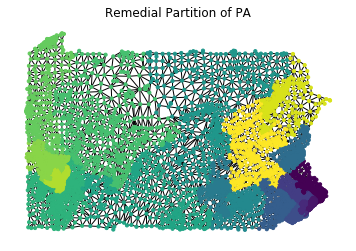

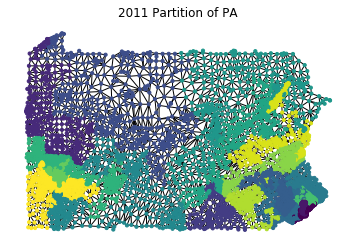

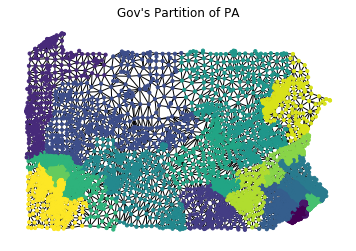

In [185]:
plt.figure()
plt.title("Remedial Partition of PA")
nx.draw(graph_PA,pos=pos_PA, node_color=[remedial_PA.assignment[x] for x in graph_PA.nodes()],
        node_size=10)
plt.show()

plt.figure()
plt.title("2011 Partition of PA")
nx.draw(graph_PA,pos=pos_PA, node_color=[PA_2011.assignment[x] for x in graph_PA.nodes()],
        node_size=10)
plt.show()

plt.figure()
plt.title("Gov's Partition of PA")
nx.draw(graph_PA,pos=pos_PA, node_color=[PA_Gov.assignment[x] for x in graph_PA.nodes()],
        node_size=10)
plt.show()

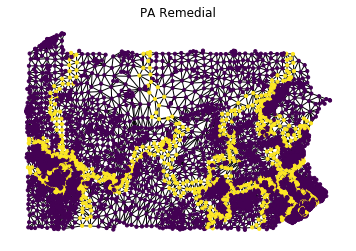

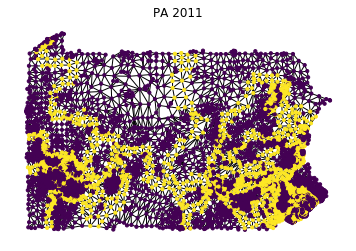

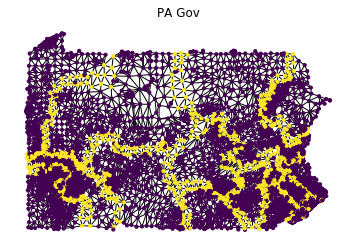

In [45]:
bn_rem = reduce(lambda ns, e: set(e) | ns , remedial_PA["cut_edges"], set())
plt.figure()
plt.title("PA Remedial")
nx.draw(graph_PA,pos=pos_PA, node_color=[x in bn_rem for x in graph_PA.nodes()], node_size=10)
plt.show()

bn_2011 = reduce(lambda ns, e: set(e) | ns , PA_2011["cut_edges"], set())
plt.figure()
plt.title("PA 2011")
nx.draw(graph_PA,pos=pos_PA, node_color=[x in bn_2011 for x in graph_PA.nodes()], node_size=10)
plt.show()

bn_gov = reduce(lambda ns, e: set(e) | ns , PA_Gov["cut_edges"], set())
plt.figure()
plt.title("PA Gov")
nx.draw(graph_PA,pos=pos_PA, node_color=[x in bn_gov for x in graph_PA.nodes()], node_size=10)
plt.show()

In [46]:
print("GOV:", len(bn_gov))
print("Rem:", len(bn_rem))
print("Intersection:", len(bn_gov & bn_rem))

GOV: 1437
Rem: 1423
Intersection: 618


In [16]:
rem_gov_data = random_pair_walks(remedial_PA, PA_Gov, iters=100)
rem_gov = np.ndarray.flatten(np.array(rem_gov_data))

gov_rem_data = random_pair_walks(PA_Gov, remedial_PA, iters=100)
gov_rem = np.ndarray.flatten(np.array(gov_rem_data))

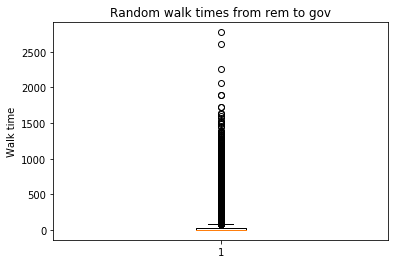

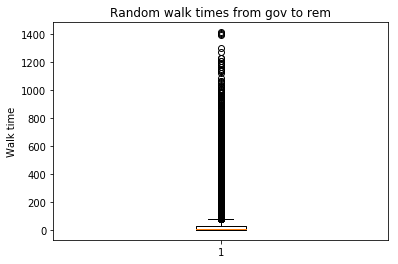

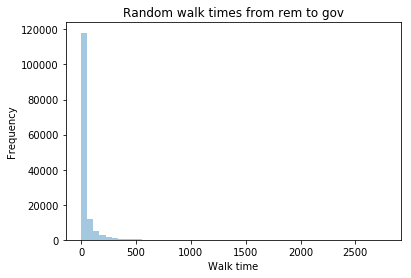

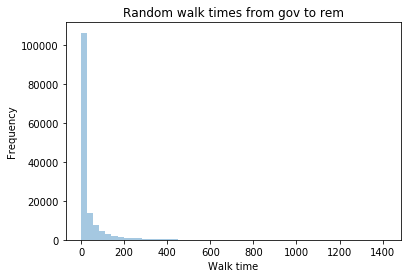

REM-GOV Mean 34.43282501756852
REM-GOV Median 2.0
GOV-REM Mean 32.55279749478079
GOV-REM Median 3.0


In [37]:
# plt.figure()
# plt.title("Random walk times from initial partition to recom partition")
# plt.ylabel("Walk time")
# plt.xlabel("Sorted random walks")
# for times in  walk_bound_time_data:
#     plt.plot(sorted(times), "bo")
# plt.show()

plt.figure()
plt.title("Random walk times from rem to gov")
plt.ylabel("Walk time")
plt.boxplot(rem_gov)
plt.show()

plt.figure()
plt.title("Random walk times from gov to rem")
plt.ylabel("Walk time")
plt.boxplot(gov_rem)
plt.show()

plt.figure()
plt.title("Random walk times from rem to gov")
plt.xlabel("Walk time")
plt.ylabel("Frequency")
sns.distplot(rem_gov, kde=False, hist=True)
plt.show()

plt.figure()
plt.title("Random walk times from gov to rem")
plt.xlabel("Walk time")
plt.ylabel("Frequency")
sns.distplot(gov_rem, kde=False, hist=True)
plt.show()

print("REM-GOV Mean", np.mean(rem_gov))
print("REM-GOV Median", np.median(rem_gov))

print("GOV-REM Mean", np.mean(gov_rem))
print("GOV-REM Median", np.median(gov_rem))

Random walks from Republican plan to 2011 plan


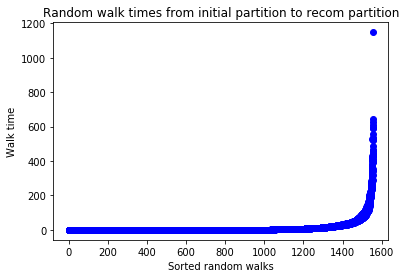

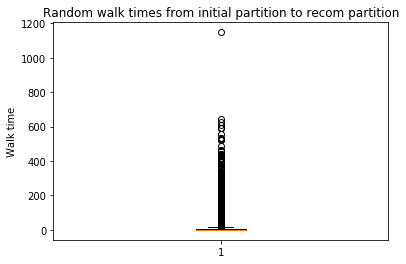

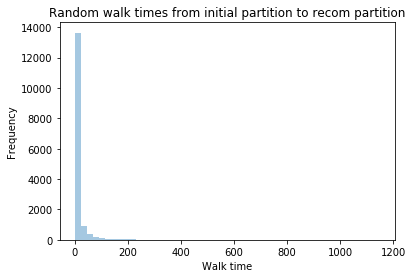

Mean 11.697045600513809
Median 0.0 

Random walks from Compactness plan to Democratic plan


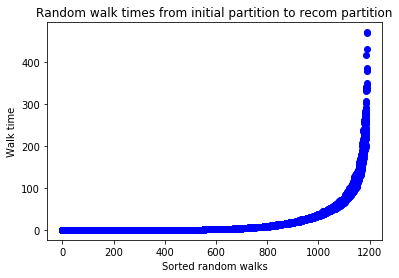

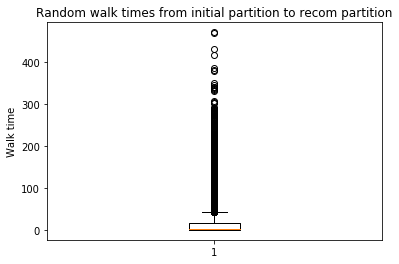

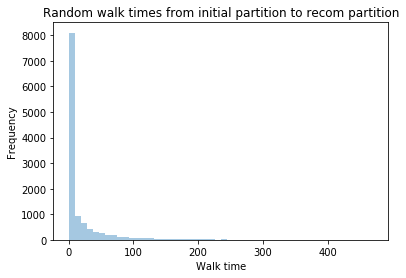

Mean 18.048780487804876
Median 1.0 

Random walks from 2011 plan to Governor’s plan


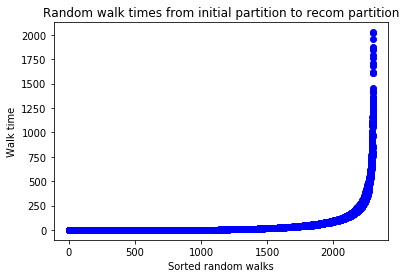

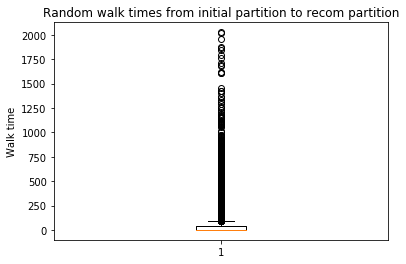

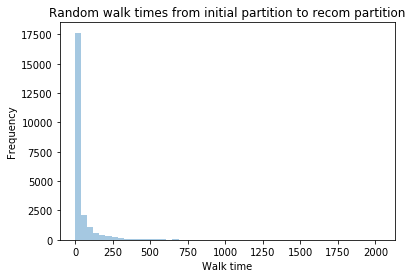

Mean 43.56449652777778
Median 4.0 



In [201]:
for i in range(3):
    [(plan1, name1), (plan2, name2)] = random.sample(PA_plans, 2)
    
    print("Random walks from", name1, "plan to", name2, "plan")
    
    walk_bound_time_data = random_pair_walks(plan1, plan2, iters=10)
    walk_bound_times = np.ndarray.flatten(np.array(walk_bound_time_data))
    
    plt.figure()
    plt.title("Random walk times from initial partition to recom partition")
    plt.ylabel("Walk time")
    plt.xlabel("Sorted random walks")
    for times in  walk_bound_time_data:
        plt.plot(sorted(times), "bo")
    plt.show()

    plt.figure()
    plt.title("Random walk times from initial partition to recom partition")
    plt.ylabel("Walk time")
    plt.boxplot(walk_bound_times)
    plt.show()

    plt.figure()
    plt.title("Random walk times from initial partition to recom partition")
    plt.xlabel("Walk time")
    plt.ylabel("Frequency")
    sns.distplot(walk_bound_times, kde=False)
    plt.show()

    print("Mean", np.mean(walk_bound_times))
    print("Median", np.median(walk_bound_times), "\n")
    
    

### Behavoir of Random Walks
On the initial_partition with random walks from district 1 to district 2

In [69]:
time_data = random_pair_walks('1', '2', initial_partition)

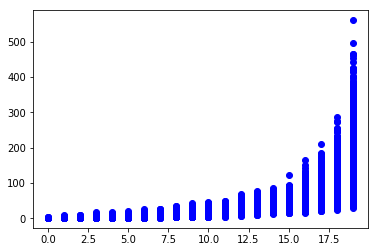

In [70]:
for times in time_data:
    plt.plot(sorted(times), "bo")

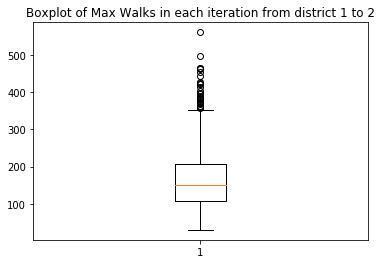

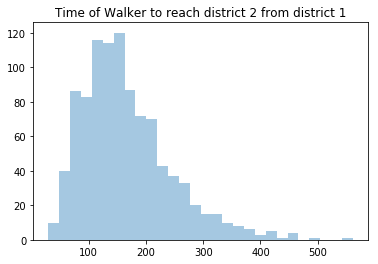

Mean: 165.826
Median: 151.0


In [75]:
maxes = list(map(max, time_data))
plt.figure()
plt.title("Boxplot of Max Walks in each iteration from district 1 to 2")
plt.boxplot(maxes)
plt.show()

plt.figure()
plt.title("Time of Walker to reach district 2 from district 1")
sns.distplot(maxes, kde=False);
plt.show()

print("Mean:", np.mean(maxes))
print("Median:", np.median(maxes))

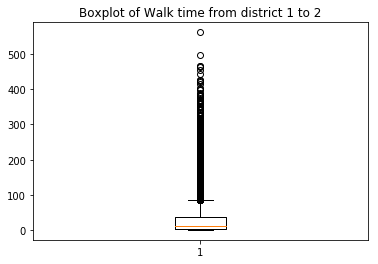

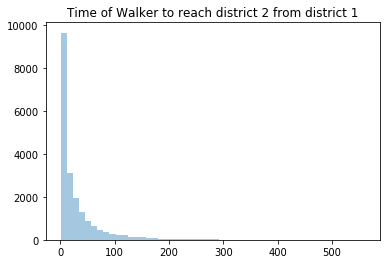

Mean 30.8365
Median 13.0


In [77]:
all_times = np.ndarray.flatten(np.array(time_data))
plt.figure()
plt.title("Boxplot of Walk time from district 1 to 2")
plt.boxplot(all_times)
plt.show()

plt.figure()
plt.title("Time of Walker to reach district 2 from district 1")
sns.distplot(all_times, kde=False);
plt.show()

print("Mean", np.mean(all_times))
print("Median", np.median(all_times))